## Estimating a water level optically using the camera configuration and a cross section

If you do not have the means to measure a water level from incoming new videos of a scene, but you do have a fully configured camera configuration and a *in situ* measured cross section, you may assess the water level by automatic optical inference of the water level along the cross section. In this notebook we demonstrate how you can use these methods.

Before you dive into this notebook, we recommend to first look at **notebook 01**, how to establish a camera configuration.

In [1]:
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
import pyorc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

The starting point for measuring a water level in an incoming video is an existing camera configuration, which provides the information on the camera's perspective. 

Also, we require a cross section. The way the water level measurement approach works is roughly as follows:

- the algorithm hypothesizes a randomly chosen possible location in the cross section as being the location where the cross section is exactly on the edge of the water surface.
- At that location, the algorithm draws a line, perpendicular to the cross-section as a hypothesis of being the water line.
- The algorithm then creates horizontally oriented rectangles, left and right of the hypothesized water line, projects these to the image, and samples intensities from a derived image of the incoming video.
- The intensity distributions of both rectangles are compared. If the distributions are very different it is more likely that the drawn line indeed represented the water line, if they are quite similar it is less likely.
- The algorithm uses a search method to repeatedly do this analysis and find the location where the intensity distribution function are the most dissimilar. The vertical level belonging to this cross-section location is retrieved and returned to the user.

Below we show what the cross section object contains, and show how it can be used to estimate the water level.

First we load in a cross section, a video, and a camera configuration. Note:
- we use here the same video as before, but you can use any video with any water level as long as it belongs to the same camera configuration and the cross section reaches far enough into the banks to be able to detect it crossing the water surface.
- we only use a single frame from the video as we don't need to interpret movements.

In [2]:
cam_config = pyorc.load_camera_config("ngwerere/ngwerere.json")
# cs_file = "ngwerere_cross_section_new.csv"
cs_file = "ngwerere/cross_section2.geojson"
video_file = "ngwerere/ngwerere_20191103.mp4"

# we load the video as before
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=1,
    h_a=0.,
)

# the cross section is stored in a simple geojson point (x, y, z) file
cs_gdf = gpd.read_file(cs_file)
cross_section = pyorc.CrossSection(camera_config=cam_config, cross_section=cs_gdf)
cross_section

Scanning video: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


LINESTRING Z (642732.4200000002 8304297.063 1182.3, 642732.5810000001 8304297.032 1182.15, 642732.7409999999 8304297.001 1182.1, 642732.8780000003 8304296.974 1182.1, 642733.0150000001 8304296.948 1182.1, 642733.152 8304296.922 1182.1, 642733.3050000002 8304296.892000001 1182.05, 642733.458 8304296.862 1182, 642733.635 8304296.828 1181.967, 642733.8119999999 8304296.794 1181.933, 642733.99 8304296.76 1181.9, 642734.1429999999 8304296.73 1181.85, 642734.2959999999 8304296.7 1181.8, 642734.4370000002 8304296.673 1181.867, 642734.5770000005 8304296.646 1181.933, 642734.7180000003 8304296.619 1182, 642734.871 8304296.589 1182, 642735.0230000004 8304296.56 1182, 642735.176 8304296.53 1182, 642735.34 8304296.499 1182.033, 642735.5040000002 8304296.467 1182.2, 642735.6690000005 8304296.435 1182.3, 642735.8349999998 8304296.403 1182.3, 642736.0010000002 8304296.371 1182.3, 642736.1660000001 8304296.339 1182.3)

We see a linestring representation of the cross section points. You can clearly see that the linestring contains our x, y and z real-world coordinates. But we want to see a more clear picture. Let's plot this in 3D

C:\Users\dhaba\AppData\Local\Temp\ipykernel_21524\3994297915.py:1: UserWarning: No water level is provided. Camera configuration reference water level is used.
  ax = cross_section.plot()


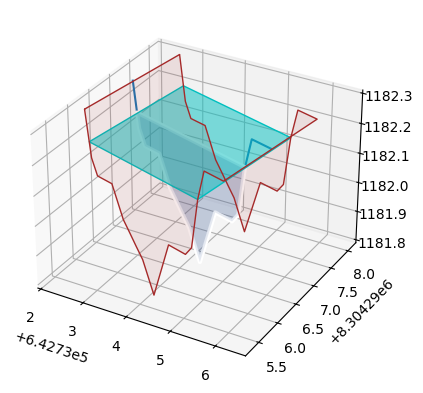

In [3]:
ax = cross_section.plot()


Interesting plot, but it would also be good to see what it looks like from the camera perspective. Let's plot both in 2 different subplots. The first subplot is a simple 2D axes with a RGB frame from our video. But we add an augmented reality of the cross section with `camera=True`. We can control what we exactly want to see with the `bottom`, `planar` and `wetted` flags. We can also control the plot keyword arguments like line width, alpha level, and so on for all through `bottom_kwargs`, `planar_kwargs` and `wetted_kwargs`We also add the camera configuration to both.

C:\Users\dhaba\AppData\Local\Temp\ipykernel_21524\1485782648.py:9: UserWarning: No water level is provided. Camera configuration reference water level is used.
  cross_section.plot(camera=True, ax=ax1, planar=False, bottom_kwargs={"alpha": 0.6, "color": "brown"})
C:\Users\dhaba\AppData\Local\Temp\ipykernel_21524\1485782648.py:14: UserWarning: No water level is provided. Camera configuration reference water level is used.
  cross_section.plot(ax=ax2)


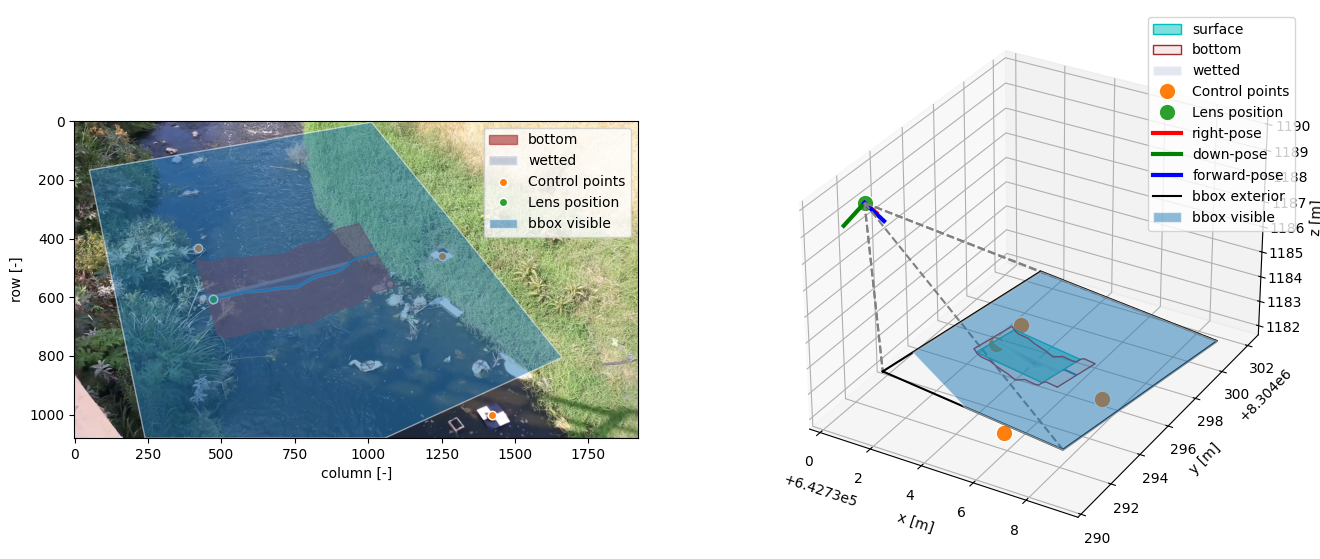

In [4]:
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(1, 2, 1)
# for the 3D plot, we need to explicitly define a 3d projection
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
# now plot an image on the first 
frame = video.get_frames(method="rgb")[0]
ax1.imshow(frame)  # .frames.plot(ax=ax1)
# on top of this, plot the cross section WITH camera=True, we skip the planar surface and make the bottom look a bit stronger.
cross_section.plot(camera=True, ax=ax1, planar=False, bottom_kwargs={"alpha": 0.6, "color": "brown"})
# and add the camera config too!
cross_section.camera_config.plot(mode="camera", ax=ax1)

# and do the 3d plot also
cross_section.plot(ax=ax2)
cross_section.camera_config.plot(mode="3d", ax=ax2)
ax2.set_aspect("equal")

Now we have a slightly better impression of the situation at the site and how our cross section fits with the camera configuration. Remember from the first notebook, that as this video is only one snapshot, we have set `h_ref` to 0.0 meters. This means that our optical measurement method should give us about 0.0 meters as water level. Let's exxtract one grayscale image and see how this goes.

In [5]:
img = video.get_frames()[0].values  # we use "values" as we need a raw numpy array
h = cross_section.detect_water_level(img)
print(f"The optimized water level is {h} meters")


The optimized water level is 0.05456036744294579 meters


You should see something near 0.055 meters. As this is from an optmization algorithm the exact value may vary a little bit. Not bad at all as this is only about 5cm from the known water level! We can now also make a plot, that shows the wetted cross section at this level

C:\Users\dhaba\AppData\Local\Temp\ipykernel_21524\1530537871.py:6: UserWarning: No water level is provided. Camera configuration reference water level is used.
  cross_section.plot(camera=True, ax=ax, planar=False, bottom_kwargs={"alpha": 0.4, "color": "brown"})
C:\Users\dhaba\AppData\Local\Temp\ipykernel_21524\1530537871.py:12: UserWarning: No water level is provided. Camera configuration reference water level is used.
  cross_section.plot(ax=ax2)


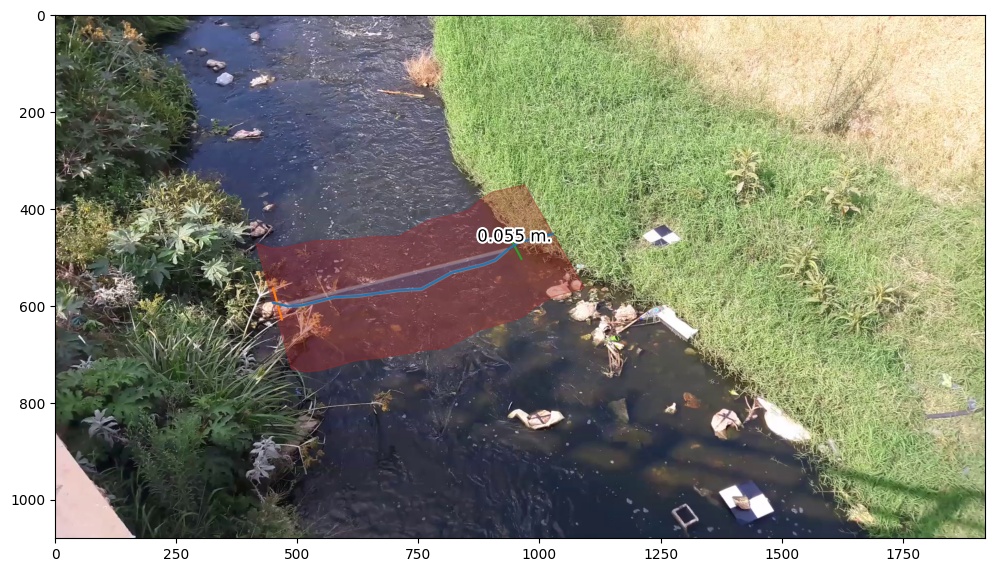

In [6]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
# plot the rgb image
ax.imshow(frame)  # .frames.plot(ax=ax1)
# on top of this, plot our new water level, with also the water line, using 2 plot methods
cross_section.plot(camera=True, ax=ax, planar=False, bottom_kwargs={"alpha": 0.4, "color": "brown"})
cross_section.plot_water_level(h=h, camera=True, ax=ax)
# and add the camera config too!
cross_section.camera_config.plot(mode="camera", ax=ax1)

# and do the 3d plot also
cross_section.plot(ax=ax2)
cross_section.camera_config.plot(mode="3d", ax=ax2)
ax2.set_aspect("equal")

Note that the bank here, is quite clearly defined with the much more bright-colored grass. The grass is also not too short. Let's also have a look at the caveats here. We have another example video on https://zenodo.org/records/15002591.

We know that during this event the water level was **93.345 meter** in the local datum.

Retrieving or providing cached version of dataset from doi:10.5281/zenodo.15002591/20241010_081717.mp4
Hommerich video is available in C:\Users\dhaba\AppData\Local\pyorc\pyorc\Cache\20241010_081717.mp4
Retrieving or providing cached version of dataset from doi:10.5281/zenodo.15002591/hommerich_20241010_081717_pyorc_data.zip.zip
Hommerich video is available in C:\Users\dhaba\AppData\Local\pyorc\pyorc\Cache\hommerich_20241010_081717_pyorc_data.zip.zip


Scanning video: 100%|██████████| 122/122 [00:02<00:00, 51.25it/s]
C:\Users\dhaba\AppData\Local\Temp\ipykernel_21524\1198332640.py:24: UserWarning: No water level is provided. Camera configuration reference water level is used.
  cross_section.plot(ax=ax2)


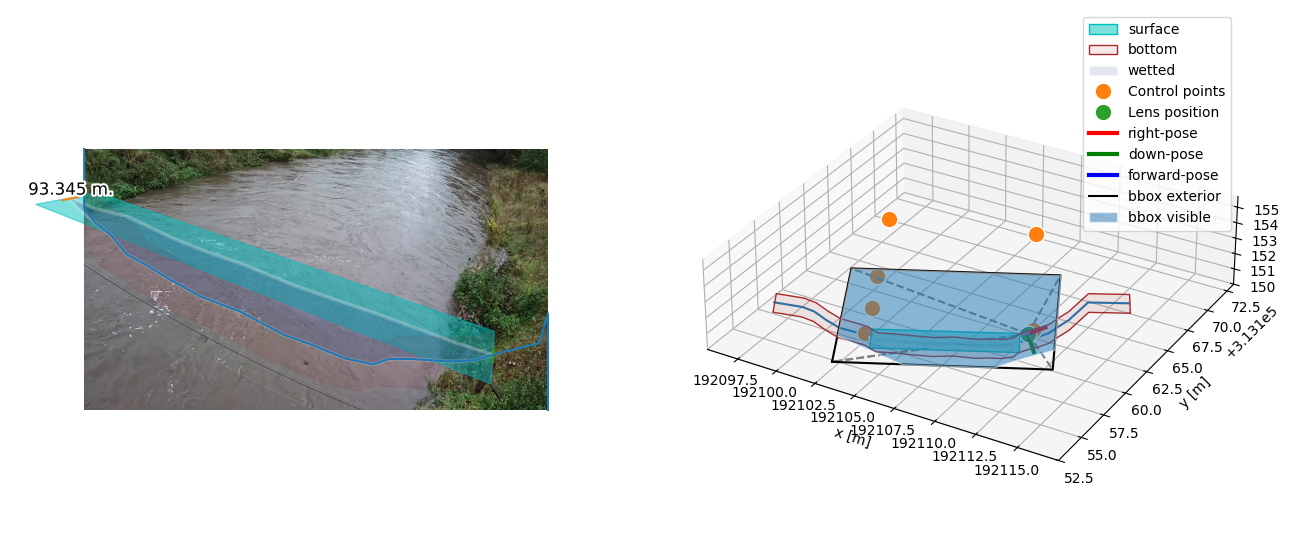

In [7]:
vid_file = pyorc.sample_data.get_hommerich_dataset()
vid_path = pyorc.sample_data.get_hommerich_pyorc_files()
cam_config_file = os.path.join(vid_path, "cam_config_gcp1.json")
cross_section_fn = os.path.join(vid_path, "cs1_ordered.geojson")

# get a new video object
cam_config = pyorc.load_camera_config(cam_config_file)
video = pyorc.Video(vid_file, camera_config=cam_config)

# get a new cross section object
gdf = gpd.read_file(cross_section_fn)
cross_section = pyorc.CrossSection(camera_config=cam_config, cross_section=gdf)

# plot together
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
frame = video.get_frames(method="rgb")[0]
ax1.imshow(frame)
# we plot with the actual water level during the video now.
cross_section.plot(camera=True, h=93.345, ax=ax1)
cross_section.plot_water_level(camera=True, h=93.345, ax=ax1)

cross_section.plot(ax=ax2)
cross_section.camera_config.plot(mode="3d", ax=ax2)
ax2.set_aspect("equal")
# switch off axis labelling
ax1.set_axis_off()

Ok, we have a new dataset, with a video taken during a high flow event. It can clearly be seen that the real wetted cross section (see left) is partly obscured by vegetation that grows over the water in the direction of the camera position. This in fact happens at both sides of the stream. That might become problematic. Let's see what happens if we extract a grayscale image, and try our best luck.

The optimized water level is 93.03156613064681 meters


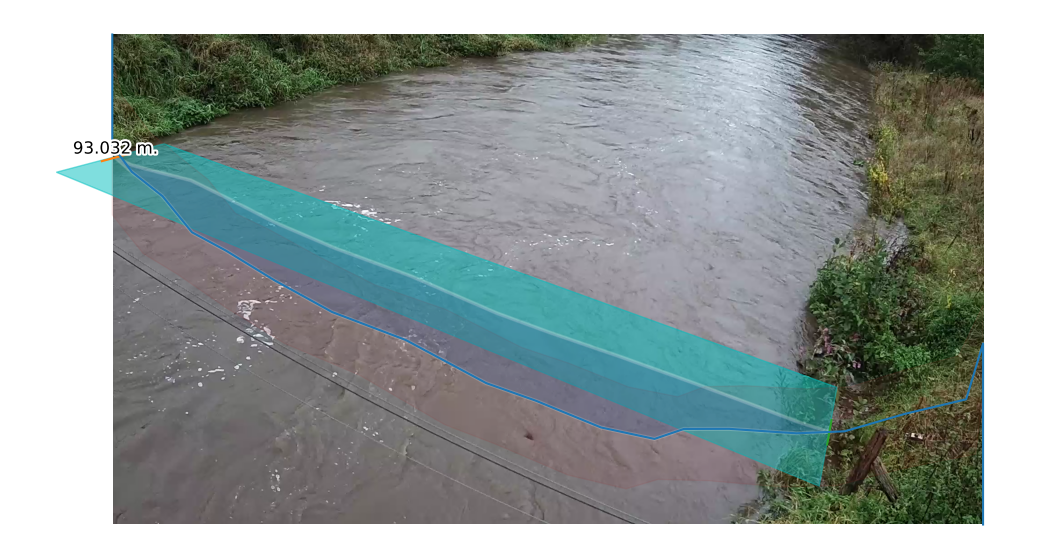

In [8]:
img = video.get_frames()[0].values
h = cross_section.detect_water_level(img)
print(f"The optimized water level is {h} meters")

# and also make a plot
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(frame)
# we plot with the actual water level during the video now.
cross_section.plot(camera=True, h=h, ax=ax)
cross_section.plot_water_level(camera=True, h=h, ax=ax)
ax.set_axis_off()



Indeed you can see that the water level is guessed to be more or less on the edge of the vegetation - water line resulting in a (much) lower water level. The land - water line is somewhere hidden under the foliage. The message is **use common sense if the situation allows for water level detection with this method**. Known circumstances where things may not work are:
* dark sand looking like water
* shaded areas
* non-moving water with mirroring reflections
* overhanging vegetation, growing towards the camera

And on the happy side, situations where this may work very well:

* if you have one or several staff gauges in view: simply draw a couple of connected points from the bottom to top of the first staff gauge, then moving horizontally to the second higher one, then the third, and so on. Just ensure that the `length` parameter is set smaller, approximately to the width of the staff gauge, and you'll have a very good contrasting cross section.
* if you have a concrete straight bridge pier or concrete channel or embankment. Easy to measure a cross section!
* arid areas with flash floods in sandy streams. Fast flowing water will have serious contrast against the much lighter sand.